In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import binned_statistic

from models import CFM
from models import Flow, FlowSubtraction
from models import Classifier
from gaussian_toy import GaussianToy
from plots import plot_naive_unfold, plot_reweighted_distribution, plot_prior_unfold, SetStyle
SetStyle()


# Create Gaussian toy example. Define six datasets:
1. Reco-level simulation
2. Gen-level simulation
3. Background simulation
4. Reco-level data
5. Gen-level data
6. Background data

In [2]:
data_params = { "n_dim": 1,
                "n_mc": 100000,
                "mc_mu": 0,
                "mc_sigma": 1,
                "n_data": 100000,
                "data_mu": 0.2,
                "data_sigma": 0.8,
                "detector_mu": 0,
                "detector_sigma": 0.5,
                "n_background": 10000,
                "background_mu": 0,
                "background_sigma": 1.2,
                "mc_rec_cut": True,
                "mc_gen_cut": True,
                "data_rec_cut": True,
                "data_gen_cut": True ,
                "efficiency": 0.1,
                "acceptance": 0.1,
                "empty_value": -5.0,
}

In [3]:
ToyModel = GaussianToy(data_params)

# Define background subtraction flow

In [4]:
bkg_mc = ToyModel.mc_background_rec

In [5]:
flow_params = { "hidden_layers": 2,
               "internal_size": 64,
               "lr": 1.e-4,
               "n_epochs" : 50,
               "batch_size" : 128,
               "batch_size_sample": 2000}

In [6]:
background_generator = Flow(dims_x = data_params['n_dim'], dims_c = 0,params = flow_params)

In [7]:
background_generator.train(bkg_mc,weights = torch.ones_like(bkg_mc[:,0]))

Training generative model for 50 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.6138337850570679 after time 1.6
    Finished epoch 10 with average loss 1.6036878824234009 after time 13.1
    Finished epoch 20 with average loss 1.6045784950256348 after time 24.7
    Finished epoch 30 with average loss 1.6034656763076782 after time 36.5
    Finished epoch 40 with average loss 1.6054784059524536 after time 48.1
    Finished epoch 49 with average loss 1.59726881980896 after time 58.5


In [8]:
generated_background = background_generator.evaluate(num_evts = ToyModel.mc_background_rec.size(0))

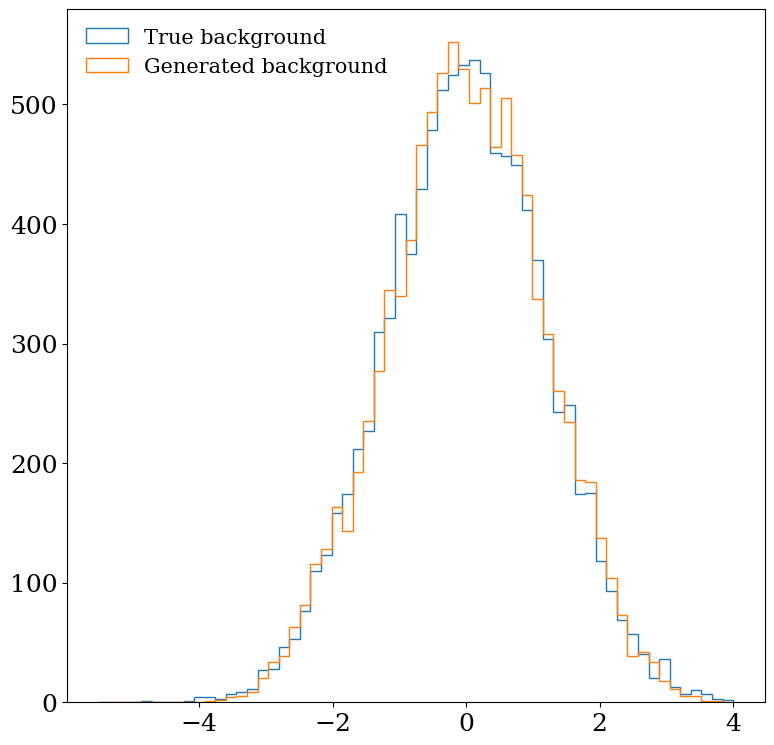

In [9]:
y_true = plt.hist(ToyModel.mc_background_rec[:,0].cpu().detach().numpy(),bins = 60, range = [-5.5,4],label = "True background", histtype='step')
y_gen = plt.hist(generated_background[:,0].cpu().detach().numpy(),bins = 60, range = [-5.5,4],label = "Generated background", histtype='step')
plt.legend()

In [10]:
if not os.path.exists("Plots"):
    os.makedirs("Plots")

with PdfPages(f"Plots/background_generated.pdf") as out:
    plot_reweighted_distribution(out, 
                                 ToyModel.mc_background_rec[:,0].cpu().detach().numpy(),
                                 generated_background[:,0].cpu().detach().numpy(),
                                 np.random.normal(0, 1.0, size=ToyModel.mc_background_rec[:,0].size(0)),
                                 range=[-3,4], labels=[r"true background" , "gaussian", "background generated",], name="x_1")    

/global/u2/v/vmikuni/Full_Generative_Unfolding/plots.py:194: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((y_err / y) ** 2 + (hist_errors[0] / hists[0]) ** 2)


In [11]:
signal_generator = FlowSubtraction(dims_x = data_params['n_dim'], dims_c = 0,params = flow_params,
                                   background_model = background_generator.network,
                                   bkg_fraction = data_params["n_background"]*1.0/(data_params["n_data"] +  data_params["n_background"]))

In [12]:
signal_generator.train(ToyModel.data_rec[ToyModel.data_rec_mask.bool()],weights = torch.ones_like(ToyModel.data_rec[ToyModel.data_rec_mask.bool()][:,0]))

Training generative model for 50 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.393393874168396 after time 15.5
    Finished epoch 10 with average loss 1.3923197984695435 after time 163.1
    Finished epoch 20 with average loss 1.39229416847229 after time 306.9
    Finished epoch 30 with average loss 1.3920785188674927 after time 452.4
    Finished epoch 40 with average loss 1.3919786214828491 after time 598.4
    Finished epoch 49 with average loss 1.392025113105774 after time 726.3


# Generate the signal and generate empty events at reco level

In [13]:
num_data_reco = ToyModel.data_signal_rec[:,0][ToyModel.data_rec_mask[:data_params["n_data"]].bool()].size(0)
generated_signal = signal_generator.evaluate(num_evts = num_data_reco) #N*(1-delta)

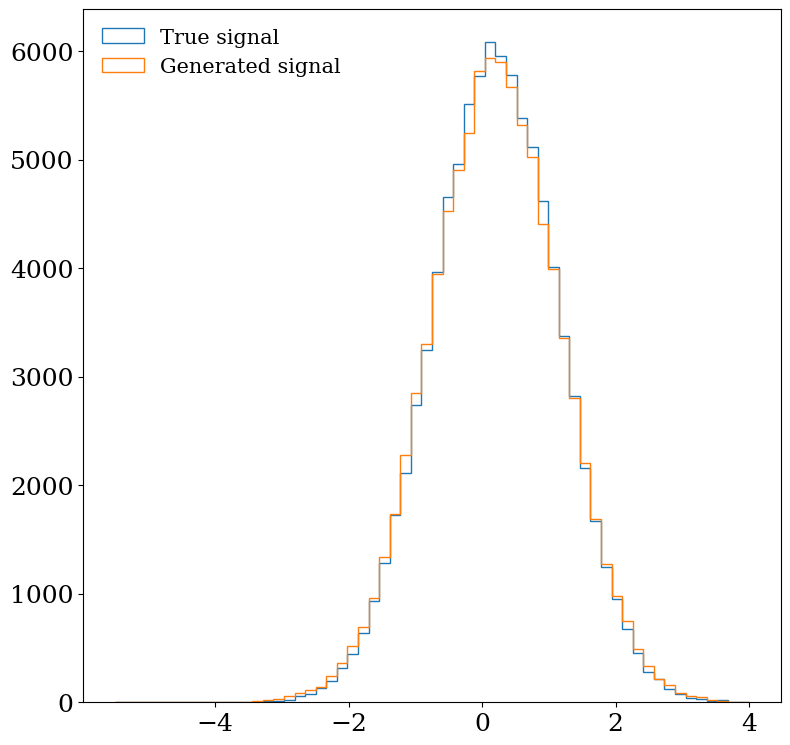

In [14]:
y_true = plt.hist(ToyModel.data_signal_rec[:,0][ToyModel.data_rec_mask[:data_params["n_data"]].bool()].cpu().detach().numpy(),bins = 60, range = [-5.5,4],label = "True signal", histtype='step')
y_gen = plt.hist(generated_signal[:,0].cpu().detach().numpy(),bins = 60, range = [-5.5,4],label = "Generated signal", histtype='step')
plt.legend()

In [15]:
num_data_empty = num_data_reco*data_params['acceptance']/(1.0 - data_params['acceptance']) #N*(1-delta)*epsilon/(1-epsilon)
#Add the empty events to the generated signals
generated_signal = torch.cat([generated_signal,data_params["empty_value"]*torch.ones_like(generated_signal[:int(num_data_empty)])])

In [16]:
print(f "Number of expected signal events in the data {generated_signal.size(0)}")

99893


# Train Acceptance classifier

In [17]:
acceptance_true = ToyModel.mc_rec[(ToyModel.mc_rec_mask.bool()) & (ToyModel.mc_gen_mask.bool())]
acceptance_false = ToyModel.mc_rec[(ToyModel.mc_rec_mask.bool()) & ~(ToyModel.mc_gen_mask.bool())]

In [18]:
acceptance_classifier_params = { "hidden_layers": 4,
                                 "internal_size": 64,
                                 "lr": 1.e-4,
                                 "n_epochs" : 30,
                                 "batch_size" : 128,
                                 "batch_size_sample": 2000
}

In [19]:
acceptance_classifier = Classifier(dims_in=1, params=acceptance_classifier_params)

In [20]:
acceptance_classifier.train_classifier(acceptance_true, acceptance_false, balanced=False)

    Training with unbalanced training set with weight 9.023817473567057
Training classifier for 270 epochs with lr 0.0001
    Finished epoch 0 with average loss 6.482643127441406 after time 0.3
    Finished epoch 54 with average loss 3.2530548572540283 after time 15.8
    Finished epoch 108 with average loss 3.253225564956665 after time 31.4
    Finished epoch 162 with average loss 3.2533464431762695 after time 47.2
    Finished epoch 216 with average loss 3.2531704902648926 after time 62.9
    Finished epoch 269 with average loss 3.2529022693634033 after time 78.1


# Train efficiency classifier

In [21]:
efficiency_classifier_params = { "hidden_layers": 4,
                                 "internal_size": 64,
                                 "lr": 1.e-4,
                                 "n_epochs" : 30,
                                 "batch_size" : 128,
                                 "batch_size_sample": 2000
}

In [22]:
efficiency_true = ToyModel.mc_gen[(ToyModel.mc_rec_mask.bool()) & (ToyModel.mc_gen_mask.bool())]
efficiency_false = ToyModel.mc_gen[~(ToyModel.mc_rec_mask.bool()) & (ToyModel.mc_gen_mask.bool())]

In [23]:
efficiency_classifier = Classifier(dims_in = 1, params = efficiency_classifier_params)

In [24]:
efficiency_classifier.train_classifier(efficiency_true, efficiency_false, balanced=False)

    Training with unbalanced training set with weight 9.040923282783229
Training classifier for 270 epochs with lr 0.0001
    Finished epoch 0 with average loss 6.326557636260986 after time 0.3
    Finished epoch 54 with average loss 3.255502939224243 after time 15.8
    Finished epoch 108 with average loss 3.255218267440796 after time 31.2
    Finished epoch 162 with average loss 3.254960775375366 after time 46.6
    Finished epoch 216 with average loss 3.255110740661621 after time 61.9
    Finished epoch 269 with average loss 3.2550418376922607 after time 76.8


# Let's train the detector response flow p(reco|gen) and the initial p(gen) flows

In [25]:
gen_generator = Flow(dims_x = data_params['n_dim'], dims_c = 0,params = flow_params)

In [26]:
gen_generator.train(ToyModel.mc_gen[ToyModel.mc_gen_mask.bool()],weights = torch.ones_like(ToyModel.mc_gen[ToyModel.mc_gen_mask.bool()][:,0]))

Training generative model for 50 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.4169052839279175 after time 9.9
    Finished epoch 10 with average loss 1.4163825511932373 after time 113.0
    Finished epoch 20 with average loss 1.4165796041488647 after time 215.8
    Finished epoch 30 with average loss 1.416462779045105 after time 320.2
    Finished epoch 40 with average loss 1.4164342880249023 after time 424.7
    Finished epoch 49 with average loss 1.4164326190948486 after time 516.2


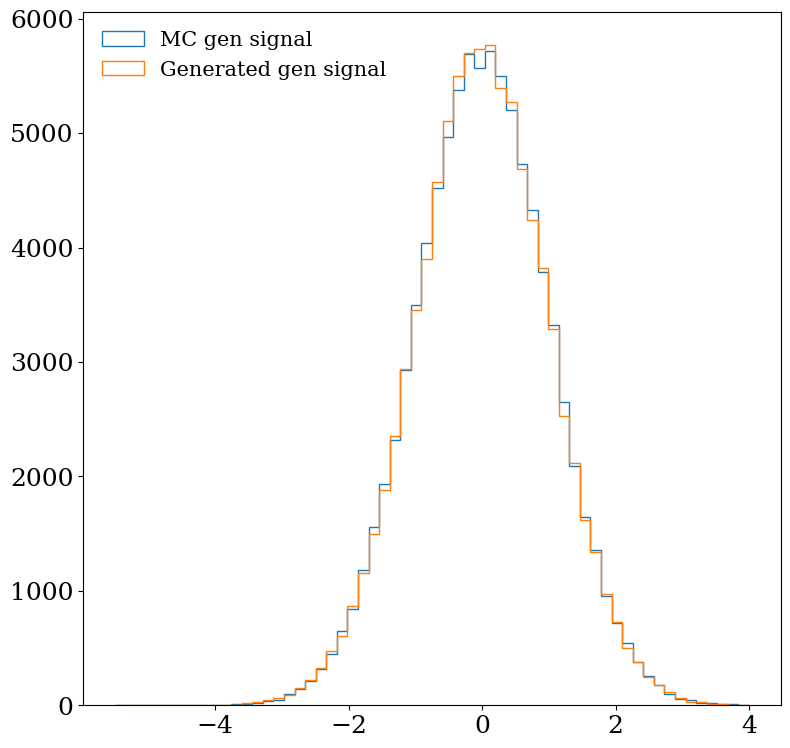

In [27]:
y_true = plt.hist(ToyModel.mc_gen[:,0][ToyModel.mc_gen_mask.bool()].cpu().detach().numpy(),
                  bins = 60, range = [-5.5,4],label = "MC gen signal", histtype='step')
y_gen = plt.hist(gen_generator.evaluate(num_evts = ToyModel.mc_gen[ToyModel.mc_gen_mask.bool()].size(0)).cpu().detach().numpy(),
                 bins = 60, range = [-5.5,4],label = "Generated gen signal", histtype='step')
plt.legend()

In [28]:
detector_generator = Flow(dims_x = data_params['n_dim'], dims_c = data_params['n_dim'],params = flow_params)

In [29]:
detector_generator.train(ToyModel.mc_rec[ToyModel.mc_rec_mask.bool()],
                         weights = torch.ones_like(ToyModel.mc_rec[ToyModel.mc_rec_mask.bool()][:,0]), 
                         data_c = ToyModel.mc_gen[ToyModel.mc_rec_mask.bool()])

using conditional model
Training generative model for 50 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.9483599066734314 after time 11.0
    Finished epoch 10 with average loss 0.8259660601615906 after time 123.7
    Finished epoch 20 with average loss 0.8163910508155823 after time 236.2
    Finished epoch 30 with average loss 0.8132712841033936 after time 348.0
    Finished epoch 40 with average loss 0.8116007447242737 after time 461.8
    Finished epoch 49 with average loss 0.8111230731010437 after time 562.6


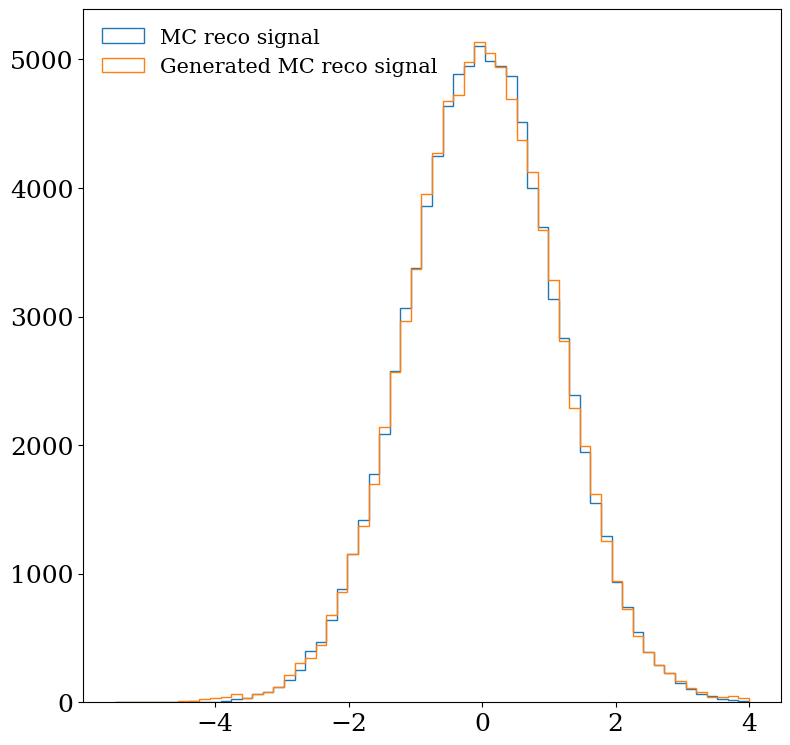

In [30]:
y_true = plt.hist(ToyModel.mc_rec[:,0][ToyModel.mc_rec_mask.bool()].cpu().detach().numpy(),
                  bins = 60, range = [-5.5,4],label = "MC reco signal", histtype='step')
y_gen = plt.hist(detector_generator.evaluate(data_c = ToyModel.mc_gen[ToyModel.mc_rec_mask.bool()]).cpu().detach().numpy(),
                 bins = 60, range = [-5.5,4],label = "Generated MC reco signal", histtype='step')
plt.legend()

# Start the unfolding!

In [31]:
def sample_reco(nevts,empty_fraction, efficiency_classifier,detector_model,gen_model):
    ''' Generates h(reco|gen) samples by sampling from: h(reco|gen) = c(gen) + (1-c(gen))*p(reco|gen)*p(gen) '''
    gen_events = gen_model.evaluate(num_evts = nevts)
    gen_mask = ToyModel.apply_efficiency_acceptance_effects(gen_events,empty_fraction)
    gen_events[~gen_mask.bool()] = data_params["empty_value"]*torch.ones_like(gen_events[~gen_mask.bool()])
    
    efficiency = efficiency_classifier.evaluate(gen_events, return_weights=False)
    sample_efficiency = torch.bernoulli(efficiency)
    
    reco_events = detector_model.evaluate(data_c=gen_events)
    reco_events[~sample_efficiency.bool()] = data_params["empty_value"]*torch.ones_like(gen_events[~sample_efficiency.bool()])
    return  reco_events, gen_events, gen_mask 

Running iteration 0
using conditional model
Training generative model for 50 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.8302958607673645 after time 11.2
    Finished epoch 10 with average loss 0.7177351713180542 after time 123.4
    Finished epoch 20 with average loss 0.7138725519180298 after time 235.4
    Finished epoch 30 with average loss 0.7113598585128784 after time 347.8
    Finished epoch 40 with average loss 0.7102212309837341 after time 458.9
    Finished epoch 49 with average loss 0.7098780870437622 after time 558.8
Training generative model for 50 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.3423268795013428 after time 11.4
    Finished epoch 10 with average loss 1.340561032295227 after time 127.1
    Finished epoch 20 with average loss 1.3402906656265259 after time 243.2
    Finished epoch 30 with average loss 1.3400076627731323 after time 357.0
    Finished epoch 40 with average loss 1.3396921157836914 after time 507.0
    Finished ep

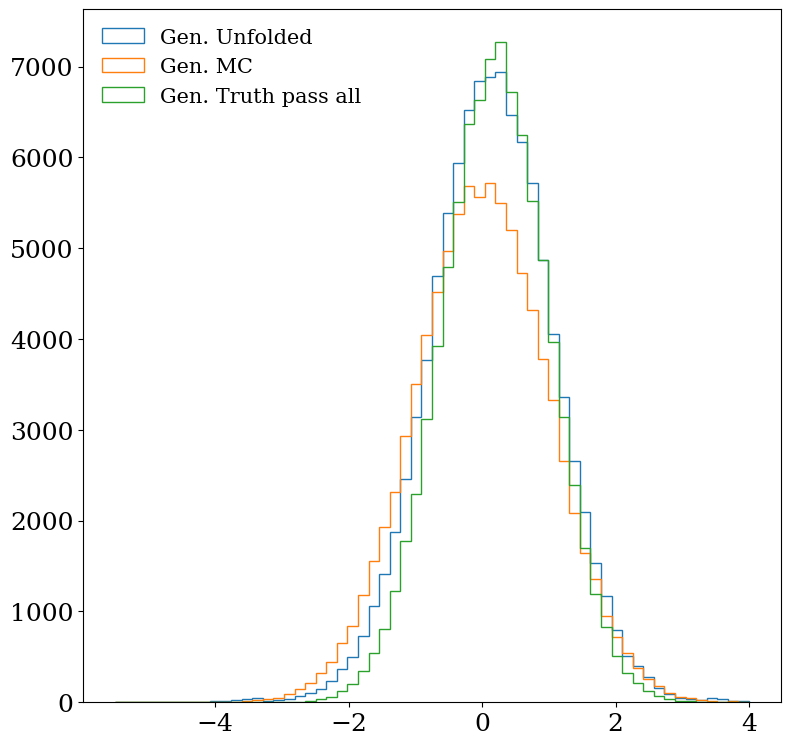

Running iteration 1
using conditional model
Training generative model for 50 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.6943761110305786 after time 10.9
    Finished epoch 10 with average loss 0.6883043050765991 after time 120.3
    Finished epoch 20 with average loss 0.6842827200889587 after time 275.6
    Finished epoch 30 with average loss 0.6828321814537048 after time 452.3
    Finished epoch 40 with average loss 0.6819030046463013 after time 631.7
    Finished epoch 49 with average loss 0.680884838104248 after time 792.2
Training generative model for 50 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.2960644960403442 after time 18.7
    Finished epoch 10 with average loss 1.2950822114944458 after time 200.8
    Finished epoch 20 with average loss 1.294637680053711 after time 384.2
    Finished epoch 30 with average loss 1.2947239875793457 after time 567.0
    Finished epoch 40 with average loss 1.2942934036254883 after time 688.8
    Finished epo

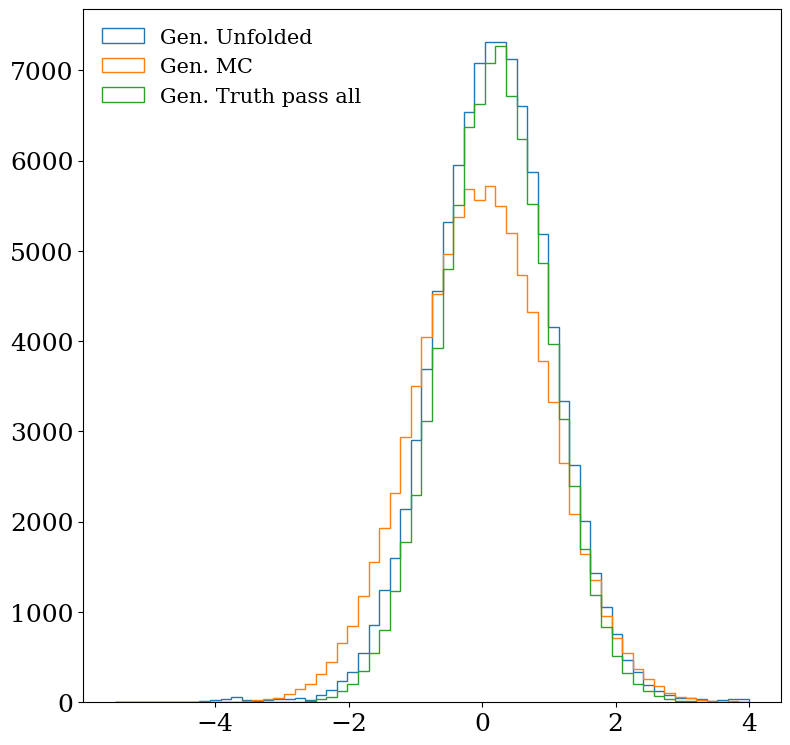

Running iteration 2
using conditional model
Training generative model for 50 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.6763375401496887 after time 11.0
    Finished epoch 10 with average loss 0.669930100440979 after time 120.3
    Finished epoch 20 with average loss 0.6683458685874939 after time 237.3
    Finished epoch 30 with average loss 0.6661697030067444 after time 350.7
    Finished epoch 40 with average loss 0.6653134822845459 after time 458.6
    Finished epoch 49 with average loss 0.664790153503418 after time 559.5
Training generative model for 50 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.2677454948425293 after time 10.9
    Finished epoch 10 with average loss 1.2671349048614502 after time 126.2
    Finished epoch 20 with average loss 1.2666428089141846 after time 239.5
    Finished epoch 30 with average loss 1.2664517164230347 after time 356.9
    Finished epoch 40 with average loss 1.2664597034454346 after time 467.2
    Finished epo

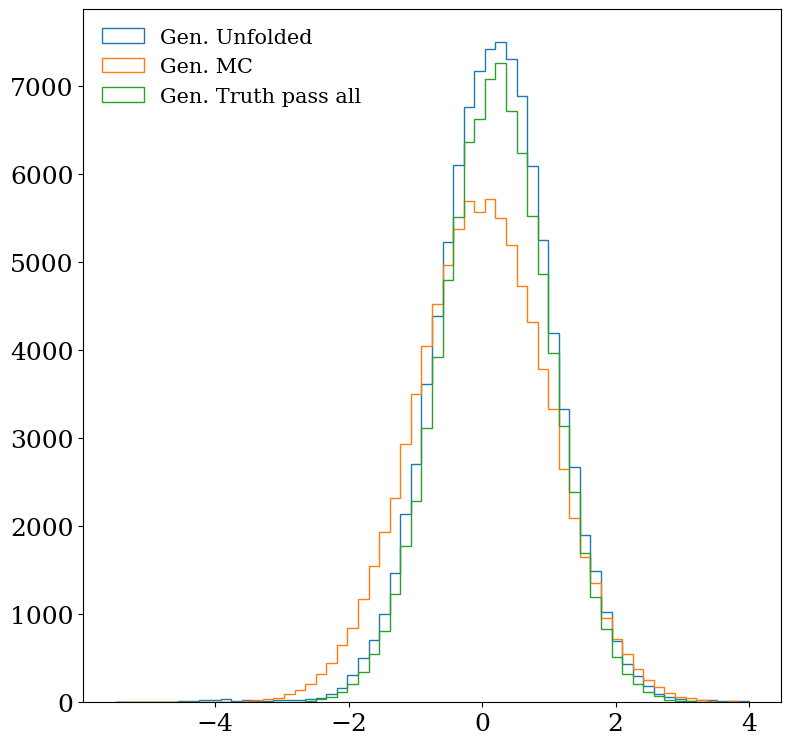

Running iteration 3
using conditional model
Training generative model for 50 epochs with lr 0.0001
    Finished epoch 0 with average loss 0.6741721034049988 after time 10.3
    Finished epoch 10 with average loss 0.6705643534660339 after time 124.0
    Finished epoch 20 with average loss 0.6692647337913513 after time 237.2
    Finished epoch 30 with average loss 0.6680605411529541 after time 345.4
    Finished epoch 40 with average loss 0.6671103835105896 after time 450.5
    Finished epoch 49 with average loss 0.6668522357940674 after time 545.9
Training generative model for 50 epochs with lr 0.0001
    Finished epoch 0 with average loss 1.266631841659546 after time 11.5


In [ ]:
iterations = 5
unfold_generator =  Flow(dims_x = data_params['n_dim'], dims_c = data_params['n_dim'],params = flow_params)
for i in range(iterations):
    print(f"Running iteration {i}")
    reco_train, gen_train, gen_mask = sample_reco(data_params['n_mc'], 
                                                 data_params['efficiency'],
                                                 efficiency_classifier,
                                                 detector_generator,
                                                 gen_generator)
    unfold_generator.train(gen_train[gen_mask.bool()], 
                           weights = torch.ones_like(gen_train[gen_mask.bool()][:,0]), 
                           data_c = reco_train[gen_mask.bool()])
    unfolded = unfold_generator.evaluate(data_c=generated_signal)
    gen_generator.train(unfolded,weights = torch.ones_like(unfolded[:,0]))
    #FIXME: Probably need to update the efficiency classifier here
    fig, axes = plt.subplots()
    axes.hist(unfolded[:,0].cpu().detach().numpy(), bins=60, histtype="step", range=[-5.5,4],label="Gen. Unfolded")
    axes.hist(ToyModel.mc_gen[:,0][ToyModel.mc_gen_mask.bool()].cpu().detach().numpy(),bins=60, histtype='step', range=[-5.5,4],label="Gen. MC")
    axes.hist(ToyModel.data_gen[:,0][ToyModel.data_gen_mask.bool()].cpu().detach().numpy(), 
              bins=60, range=[-5.5,4], histtype="step", label="Gen. Truth pass all")
    plt.legend()  # Display the legend
    plt.show()

# Fix Acceptance with empty true events

In [36]:
acceptance = acceptance_classifier.evaluate(generated_signal, return_weights=False)
acceptance_mask = torch.bernoulli(acceptance)
unfolded = unfolded[acceptance_mask.bool()]
print(f"Unfolded true events {unfolded.size(0)}, Number of true data events {torch.sum(ToyModel.data_gen_mask.bool())}")

Unfolded true events 90211, Number of true data events 90004


In [ ]:
with PdfPages(f"Plots/final_generative_unfolding.pdf") as out:
    plot_naive_unfold(out, 
                      ToyModel.data_gen[:, 0][ToyModel.data_gen_mask.bool()].cpu().detach().numpy(),
                      ToyModel.data_rec[:, 0][ToyModel.data_rec_mask.bool()].cpu().detach().numpy(),
                      unfolded[:, 0].cpu().detach().numpy(),
                      range=[-3, 4], name="x_1")